# 1. Standard (not graph) AE + GNN for node classification from AE codings

## 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
X = data.x.numpy()


# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load the Cora dataset
dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# Autoencoder Settings
input_dim = dataset.num_node_features
hidden_dim = 128
bottleneck_dim = 32
autoencoder = Autoencoder(input_dim, hidden_dim, bottleneck_dim)

# Training the Autoencoder
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.01)
criterion_ae = nn.MSELoss()

for epoch in range(200):
    autoencoder.train()
    optimizer_ae.zero_grad()
    _, reconstructed = autoencoder(data.x)
    loss = criterion_ae(reconstructed, data.x)
    loss.backward()
    optimizer_ae.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Preparing the compressed features for the GNN
autoencoder.eval()
with torch.no_grad():  # Ensure no gradients are computed for the operation within this block
    compressed_features, _ = autoencoder(data.x)
    compressed_features = compressed_features.detach()  # Detach the features from the graph


# Training the GNN
gcn = GCN(bottleneck_dim, hidden_dim, dataset.num_classes)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion_gcn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    gcn.train()
    optimizer_gcn.zero_grad()
    out = gcn(compressed_features, data.edge_index)
    loss = criterion_gcn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer_gcn.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.2501450479030609
Epoch 10, Loss: 5.793549644295126e-05
Epoch 20, Loss: 5.073233842267655e-05
Epoch 30, Loss: 5.073233842267655e-05
Epoch 40, Loss: 5.073233842267655e-05
Epoch 50, Loss: 5.073233842267655e-05
Epoch 60, Loss: 5.073233842267655e-05
Epoch 70, Loss: 5.073233842267655e-05
Epoch 80, Loss: 5.073233842267655e-05
Epoch 90, Loss: 5.073233842267655e-05
Epoch 100, Loss: 5.073233842267655e-05
Epoch 110, Loss: 5.073233842267655e-05
Epoch 120, Loss: 5.073233842267655e-05
Epoch 130, Loss: 5.073233842267655e-05
Epoch 140, Loss: 5.073233842267655e-05
Epoch 150, Loss: 5.073233842267655e-05
Epoch 160, Loss: 5.073233842267655e-05
Epoch 170, Loss: 5.073233842267655e-05
Epoch 180, Loss: 5.073233842267655e-05
Epoch 190, Loss: 5.073233842267655e-05
Epoch 0, Loss: 2.35538649559021
Epoch 10, Loss: 2.0206570625305176
Epoch 20, Loss: 1.958859920501709
Epoch 30, Loss: 1.9517475366592407
Epoch 40, Loss: 1.9445031881332397
Epoch 50, Loss: 1.948156714439392
Epoch 60, Loss: 1.94199287891

In [2]:
# Switch model to evaluation mode
gcn.eval()

# No gradient calculation needed for evaluation
with torch.no_grad():
    # Forward pass with the test data
    test_out = gcn(compressed_features, data.edge_index)
    # Use the class with the highest probability as the prediction
    test_pred = test_out.argmax(dim=1)
    # Calculate the number of correct predictions in the test set
    correct = (test_pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    # Calculate the test accuracy
    test_accuracy = correct / data.test_mask.sum().item()




## 

In [3]:
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.139


This obviously does not work. Let's try to fix it.

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 2
num_features = dataset.num_features
num_classes = dataset.num_classes
epochs = 100
hidden_channels = 16

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    

/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3580100536346436
Epoch: 20, Loss: 1.3415964841842651
Epoch: 30, Loss: 1.3210352659225464
Epoch: 40, Loss: 1.2993769645690918
Epoch: 50, Loss: 1.2702492475509644
Epoch: 60, Loss: 1.2358461618423462
Epoch: 70, Loss: 1.1960015296936035
Epoch: 80, Loss: 1.1720130443572998
Epoch: 90, Loss: 1.1508491039276123
Epoch: 100, Loss: 1.1335225105285645
Epoch 0, Loss: 2.024984359741211
Epoch 10, Loss: 1.8977994918823242
Epoch 20, Loss: 1.8282381296157837
Epoch 30, Loss: 1.786385178565979
Epoch 40, Loss: 1.7418464422225952
Epoch 50, Loss: 1.7103620767593384
Epoch 60, Loss: 1.7493332624435425
Epoch 70, Loss: 1.702035903930664
Epoch 80, Loss: 1.724082112312317
Epoch 90, Loss: 1.686099886894226


## 

In [5]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.2930


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = dataset.num_features
num_classes = dataset.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


Epoch: 10, Loss: 1.3344428539276123
Epoch: 20, Loss: 1.2725162506103516
Epoch: 30, Loss: 1.146511197090149
Epoch: 40, Loss: 1.0481303930282593
Epoch: 50, Loss: 1.0246089696884155
Epoch: 60, Loss: 0.9989781975746155
Epoch: 70, Loss: 0.9891132116317749
Epoch: 80, Loss: 0.9761044979095459
Epoch: 90, Loss: 0.9743419885635376
Epoch: 100, Loss: 0.9800298810005188
Epoch 0, Loss: 1.8882324695587158
Epoch 10, Loss: 1.3995137214660645
Epoch 20, Loss: 1.227901816368103
Epoch 30, Loss: 1.2522848844528198
Epoch 40, Loss: 1.147665023803711
Epoch 50, Loss: 1.097074031829834
Epoch 60, Loss: 1.0939298868179321
Epoch 70, Loss: 1.0422580242156982
Epoch 80, Loss: 0.9924234747886658
Epoch 90, Loss: 0.964008092880249


## 

In [7]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6270


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [55]:
local_metrics = LocalMetric()
local_metrics_tsne = LocalMetric()

dataset_name="Cora"
algorithm_name="GAE"

In [32]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features

model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.3660633563995361
Epoch: 20, Loss: 1.3497421741485596
Epoch: 30, Loss: 1.3288835287094116
Epoch: 40, Loss: 1.3043161630630493
Epoch: 50, Loss: 1.2643799781799316
Epoch: 60, Loss: 1.2095129489898682
Epoch: 70, Loss: 1.1631836891174316
Epoch: 80, Loss: 1.1548420190811157
Epoch: 90, Loss: 1.12571382522583
Epoch: 100, Loss: 1.1167457103729248


## 

Calculating d_hd
Cora GAE-basic


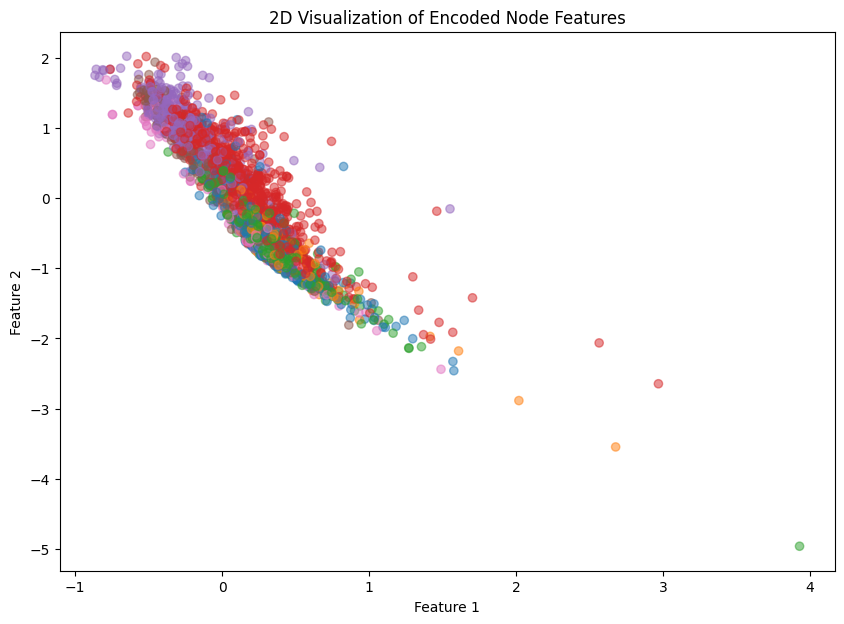

In [33]:
GAE_variant = "basic"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"),
)

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [34]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = dataset.num_features

# Model initialization
model = GAE(GCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 1.3506746292114258
Epoch: 20, Loss: 1.323014497756958
Epoch: 30, Loss: 1.284898042678833
Epoch: 40, Loss: 1.1747440099716187
Epoch: 50, Loss: 1.1314165592193604
Epoch: 60, Loss: 1.122005581855774
Epoch: 70, Loss: 1.113761305809021
Epoch: 80, Loss: 1.1103829145431519
Epoch: 90, Loss: 1.1102492809295654
Epoch: 100, Loss: 1.1101433038711548
Epoch: 110, Loss: 1.1089496612548828
Epoch: 120, Loss: 1.1054368019104004
Epoch: 130, Loss: 1.103071928024292
Epoch: 140, Loss: 1.1057524681091309
Epoch: 150, Loss: 1.1072018146514893
Epoch: 160, Loss: 1.1082757711410522
Epoch: 170, Loss: 1.1077629327774048
Epoch: 180, Loss: 1.101190447807312
Epoch: 190, Loss: 1.101086139678955
Epoch: 200, Loss: 1.106205701828003


## 

Calculating d_hd
Cora GAE-basic + tSNE


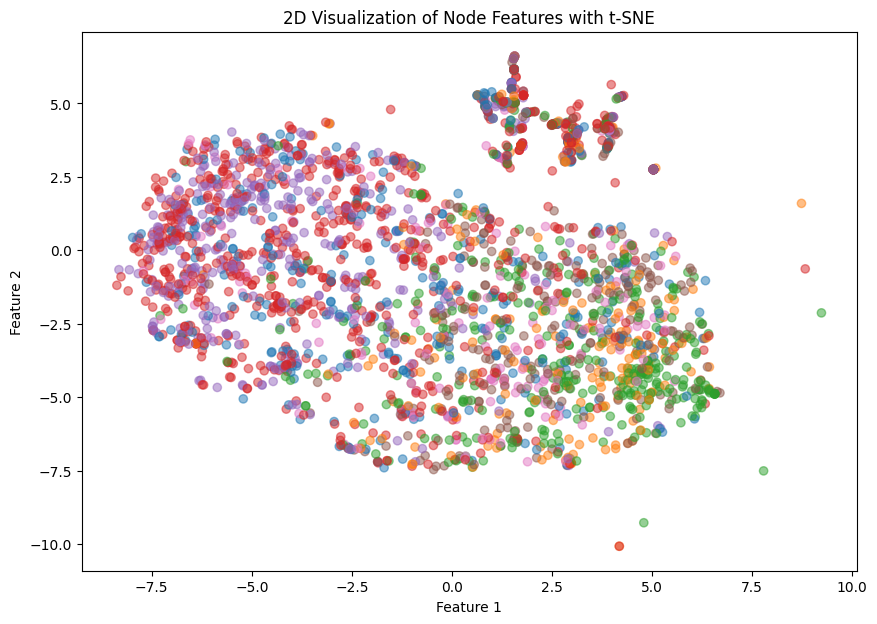

In [56]:
GAE_variant = "basic + tSNE"

local_metrics_tsne.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [57]:
class EnhancedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedGCNEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.base_conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)  # Skip connection
        self.conv3 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = F.relu(self.base_conv2(x + skip1, edge_index))  # Combine with skip connection
        return self.conv3(x, edge_index)

# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = dataset.num_features

# Model initialization
model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.3576874732971191
Epoch: 20, Loss: 1.331610918045044
Epoch: 30, Loss: 1.299635887145996
Epoch: 40, Loss: 1.2004601955413818
Epoch: 50, Loss: 1.1476480960845947
Epoch: 60, Loss: 1.1123875379562378
Epoch: 70, Loss: 1.1018729209899902
Epoch: 80, Loss: 1.1065788269042969
Epoch: 90, Loss: 1.1072285175323486
Epoch: 100, Loss: 1.1316015720367432
Epoch: 110, Loss: 1.0995476245880127
Epoch: 120, Loss: 1.1004010438919067
Epoch: 130, Loss: 1.1052390336990356
Epoch: 140, Loss: 1.0939580202102661
Epoch: 150, Loss: 1.0923607349395752
Epoch: 160, Loss: 1.0897995233535767
Epoch: 170, Loss: 1.097071886062622
Epoch: 180, Loss: 1.0866566896438599
Epoch: 190, Loss: 1.0977259874343872
Epoch: 200, Loss: 1.1185579299926758


## 

Calculating d_hd
Cora GAE-skip cons + tSNE


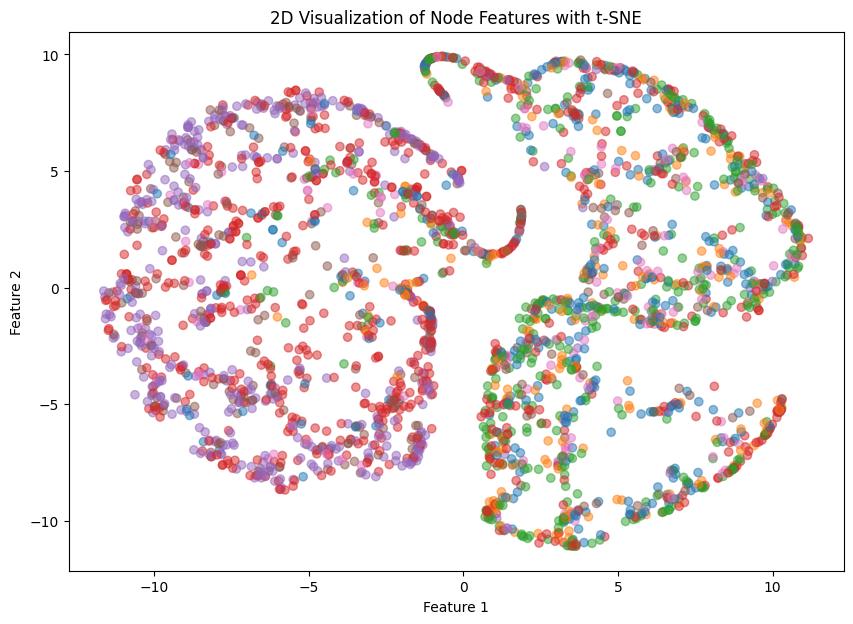

In [58]:
GAE_variant = "skip cons + tSNE"

local_metrics_tsne.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [59]:
dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features

model = GAE(EnhancedGCNEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.354856252670288
Epoch: 20, Loss: 1.3299269676208496
Epoch: 30, Loss: 1.2894785404205322
Epoch: 40, Loss: 1.2321231365203857
Epoch: 50, Loss: 1.1575347185134888
Epoch: 60, Loss: 1.1053770780563354
Epoch: 70, Loss: 1.1000292301177979
Epoch: 80, Loss: 1.102896809577942
Epoch: 90, Loss: 1.0949116945266724
Epoch: 100, Loss: 1.0911612510681152


## 

Calculating d_hd
Cora GAE-skip cons


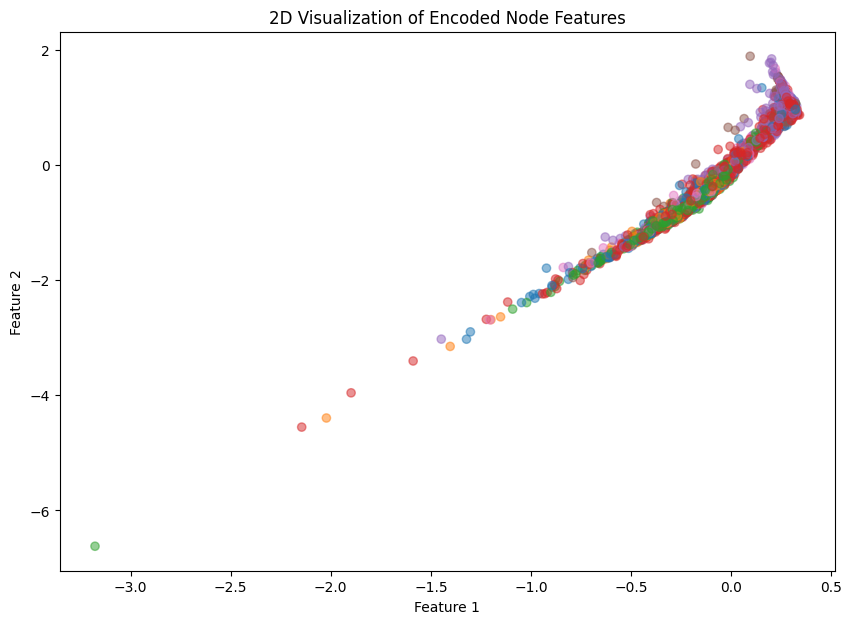

In [60]:
GAE_variant = "skip cons"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

## 

In [61]:
from torch_geometric.nn import GATConv

class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        # Concatenate multi-head outputs so the final output will be 2*out_channels*8
        self.conv2 = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features

model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

Epoch: 10, Loss: 1.3788084983825684
Epoch: 20, Loss: 1.3405864238739014
Epoch: 30, Loss: 1.2983789443969727
Epoch: 40, Loss: 1.2724568843841553
Epoch: 50, Loss: 1.2582614421844482
Epoch: 60, Loss: 1.2545487880706787
Epoch: 70, Loss: 1.2488642930984497
Epoch: 80, Loss: 1.2421298027038574
Epoch: 90, Loss: 1.2507058382034302
Epoch: 100, Loss: 1.2497156858444214
Epoch: 110, Loss: 1.2503511905670166
Epoch: 120, Loss: 1.2509675025939941
Epoch: 130, Loss: 1.2438983917236328
Epoch: 140, Loss: 1.2137421369552612
Epoch: 150, Loss: 1.2341150045394897
Epoch: 160, Loss: 1.2267531156539917
Epoch: 170, Loss: 1.2267310619354248
Epoch: 180, Loss: 1.2309200763702393
Epoch: 190, Loss: 1.2286909818649292
Epoch: 200, Loss: 1.216825246810913


## 

Calculating d_hd
Cora GAE-attention


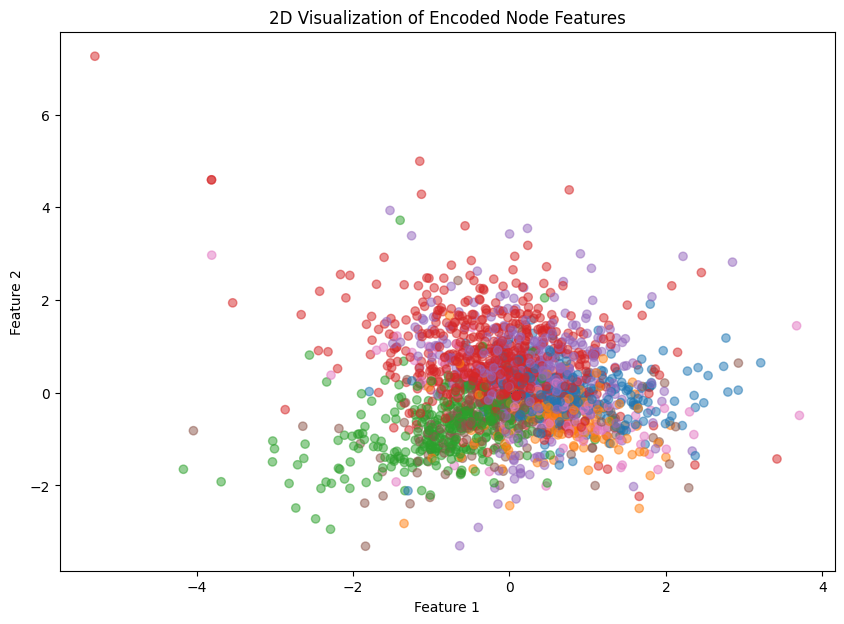

In [62]:
GAE_variant = "attention"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [63]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = dataset.num_features

# Model initialization
model = GAE(GATEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 1.384731411933899
Epoch: 20, Loss: 1.3418962955474854
Epoch: 30, Loss: 1.323264479637146
Epoch: 40, Loss: 1.2927334308624268
Epoch: 50, Loss: 1.3079166412353516
Epoch: 60, Loss: 1.2900744676589966
Epoch: 70, Loss: 1.2913818359375
Epoch: 80, Loss: 1.2923314571380615
Epoch: 90, Loss: 1.295215368270874
Epoch: 100, Loss: 1.28440260887146
Epoch: 110, Loss: 1.281764268875122
Epoch: 120, Loss: 1.2847025394439697
Epoch: 130, Loss: 1.2611253261566162
Epoch: 140, Loss: 1.2812644243240356
Epoch: 150, Loss: 1.2862522602081299
Epoch: 160, Loss: 1.2671289443969727
Epoch: 170, Loss: 1.2711641788482666
Epoch: 180, Loss: 1.2680201530456543
Epoch: 190, Loss: 1.2706000804901123
Epoch: 200, Loss: 1.2632029056549072


## 

Calculating d_hd
Cora GAE-attention + tSNE


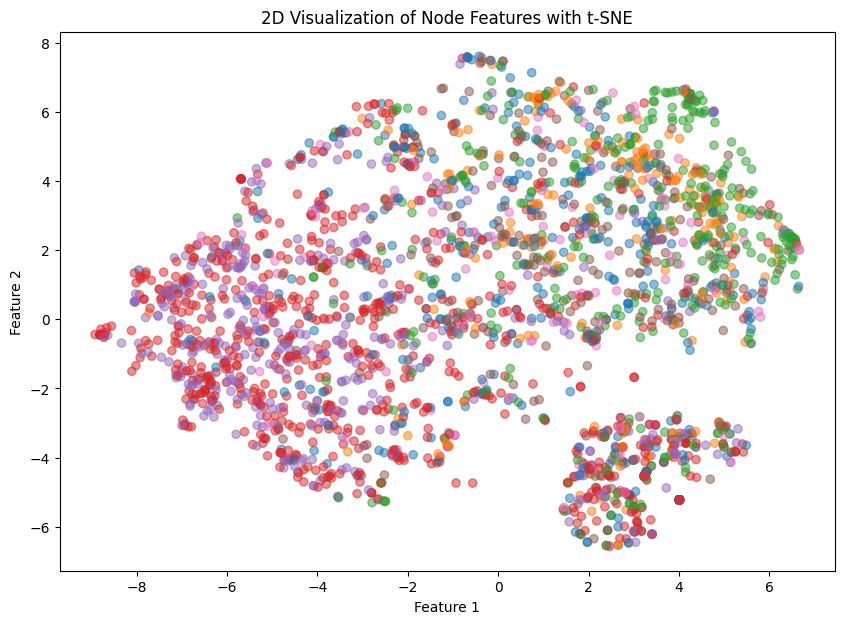

In [64]:
GAE_variant = "attention + tSNE"

local_metrics_tsne.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [65]:
class ComplexGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexGCNEncoder, self).__init__()
        # Encoder with skip connections
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.skip_conv1 = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) + x  # Residual connection
        x = self.conv3(x, edge_index) + skip1  # Skip connection
        return x

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features
hidden_channels=16

model = GAE(ComplexGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.3452157974243164
Epoch: 20, Loss: 1.3065423965454102
Epoch: 30, Loss: 1.2508389949798584
Epoch: 40, Loss: 1.1325833797454834
Epoch: 50, Loss: 1.0390243530273438
Epoch: 60, Loss: 0.992997407913208
Epoch: 70, Loss: 1.0038288831710815
Epoch: 80, Loss: 0.983321487903595
Epoch: 90, Loss: 0.9868744611740112
Epoch: 100, Loss: 0.9808788299560547
Epoch: 110, Loss: 0.9847667217254639
Epoch: 120, Loss: 0.9696402549743652
Epoch: 130, Loss: 0.972288191318512
Epoch: 140, Loss: 0.9683312177658081
Epoch: 150, Loss: 0.9679425358772278
Epoch: 160, Loss: 0.9680389165878296
Epoch: 170, Loss: 0.971777617931366
Epoch: 180, Loss: 0.9691593647003174
Epoch: 190, Loss: 0.9707090258598328
Epoch: 200, Loss: 0.9561160206794739


## 

Calculating d_hd
Cora GAE-skip + residual cons


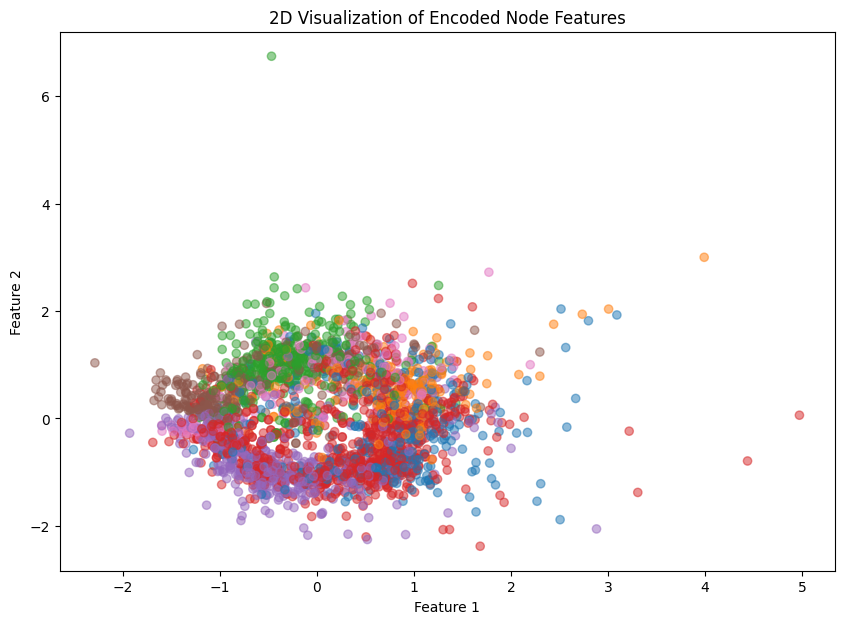

In [66]:
GAE_variant = "skip + residual cons"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [67]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)
        
        x = self.conv3(x, edge_index)
        
        x += identity  # Add the input to the output
        return x

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features
hidden_channels=16

model = GAE(ResidualGCNEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 1.3467059135437012
Epoch: 20, Loss: 1.298151969909668
Epoch: 30, Loss: 1.1992177963256836
Epoch: 40, Loss: 1.1316591501235962
Epoch: 50, Loss: 1.1088682413101196
Epoch: 60, Loss: 1.09918212890625
Epoch: 70, Loss: 1.0939245223999023
Epoch: 80, Loss: 1.0944961309432983
Epoch: 90, Loss: 1.0806735754013062
Epoch: 100, Loss: 1.0896669626235962
Epoch: 110, Loss: 1.0788553953170776
Epoch: 120, Loss: 1.078802466392517
Epoch: 130, Loss: 1.0759645700454712
Epoch: 140, Loss: 1.0689866542816162
Epoch: 150, Loss: 1.0693376064300537
Epoch: 160, Loss: 1.0505852699279785
Epoch: 170, Loss: 1.0024868249893188
Epoch: 180, Loss: 0.9966753721237183
Epoch: 190, Loss: 0.9794709086418152
Epoch: 200, Loss: 0.97771817445755


## 

Calculating d_hd
Cora GAE-residual cons


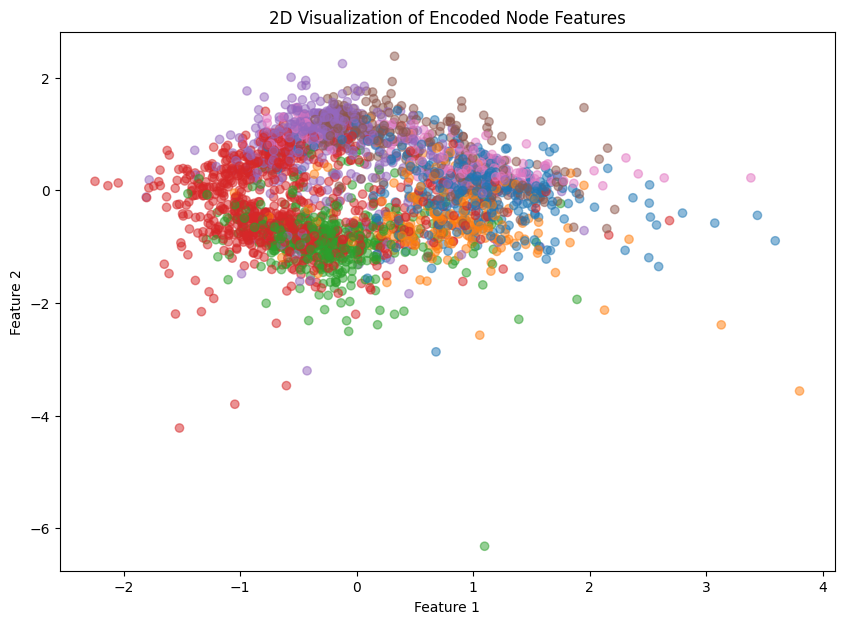

In [68]:
GAE_variant = "residual cons"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [69]:
from torch_geometric.nn import GATConv, LayerNorm

class GATWithLayerNormEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout_rate=0.6):
        super(GATWithLayerNormEncoder, self).__init__()
        # Define the first layer with multiple heads
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # For the second layer, we want to reduce the dimension to our desired output dimension
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)
        # Layer normalization
        self.ln1 = LayerNorm(hidden_channels * heads)
        self.ln2 = LayerNorm(out_channels)

    def forward(self, x, edge_index, dropout_rate=0.6):
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.ln1(x)
        x = F.dropout(x, p=dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.ln2(x)
        return x

dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
data = dataset[0]
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = dataset.num_features
hidden_channels=16

model = GAE(GATWithLayerNormEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


Epoch: 10, Loss: 1.44822359085083
Epoch: 20, Loss: 1.4240593910217285
Epoch: 30, Loss: 1.3381555080413818
Epoch: 40, Loss: 1.3261287212371826
Epoch: 50, Loss: 1.3039333820343018
Epoch: 60, Loss: 1.2998027801513672
Epoch: 70, Loss: 1.2907891273498535
Epoch: 80, Loss: 1.2898797988891602
Epoch: 90, Loss: 1.2740017175674438
Epoch: 100, Loss: 1.268671989440918
Epoch: 110, Loss: 1.2569273710250854
Epoch: 120, Loss: 1.258137583732605
Epoch: 130, Loss: 1.2432444095611572
Epoch: 140, Loss: 1.2574950456619263
Epoch: 150, Loss: 1.2345079183578491
Epoch: 160, Loss: 1.2293874025344849
Epoch: 170, Loss: 1.2416210174560547
Epoch: 180, Loss: 1.2238826751708984
Epoch: 190, Loss: 1.238471508026123
Epoch: 200, Loss: 1.2350677251815796


## 

Calculating d_hd
Cora GAE-attention + normalization


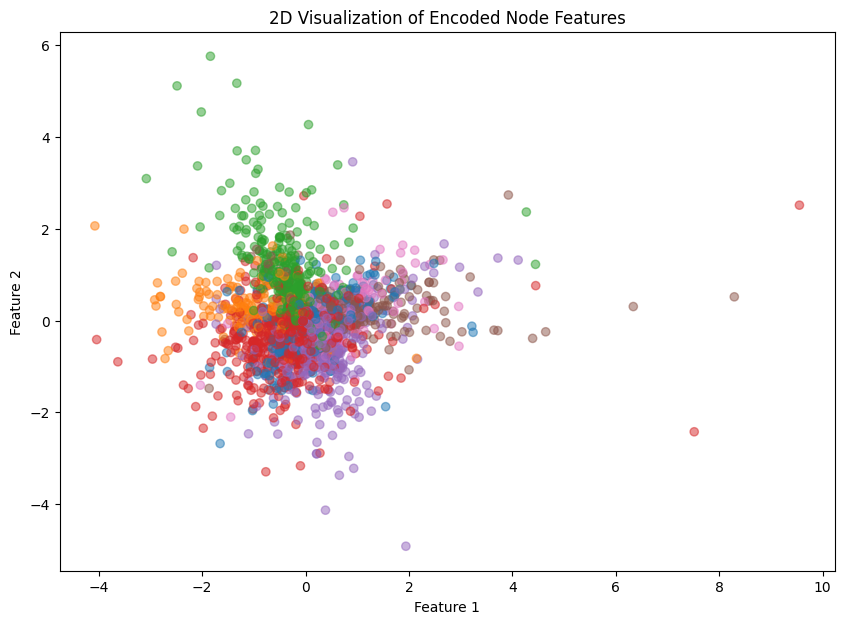

In [70]:
GAE_variant = "attention + normalization"

local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features,
    X_hds=X,
    labels=labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

Finished.


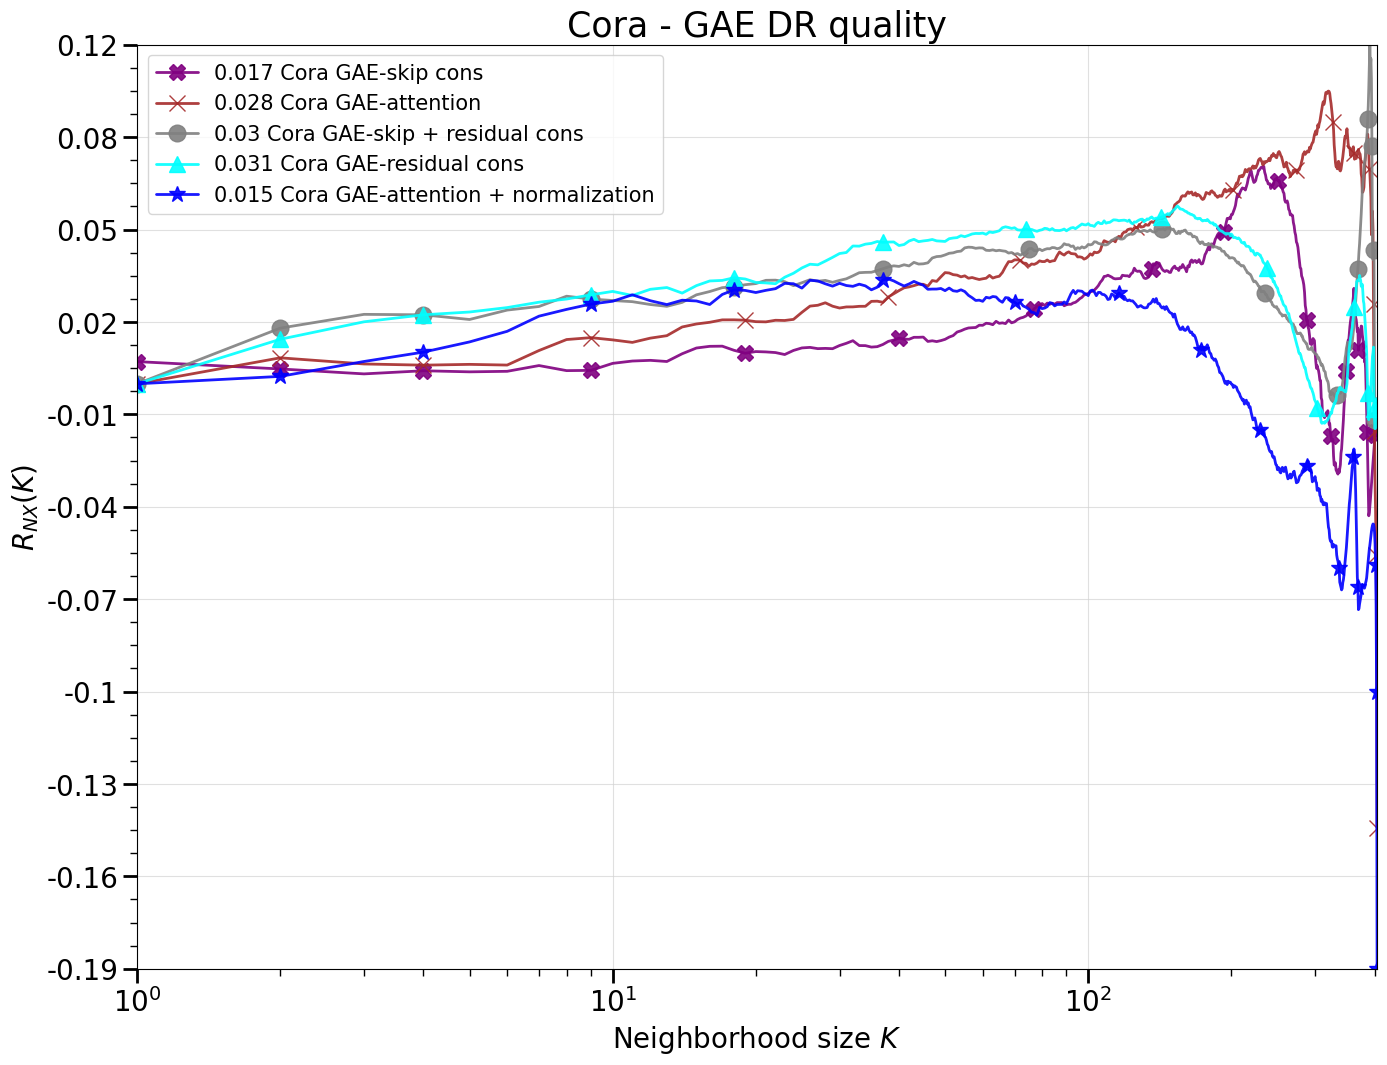

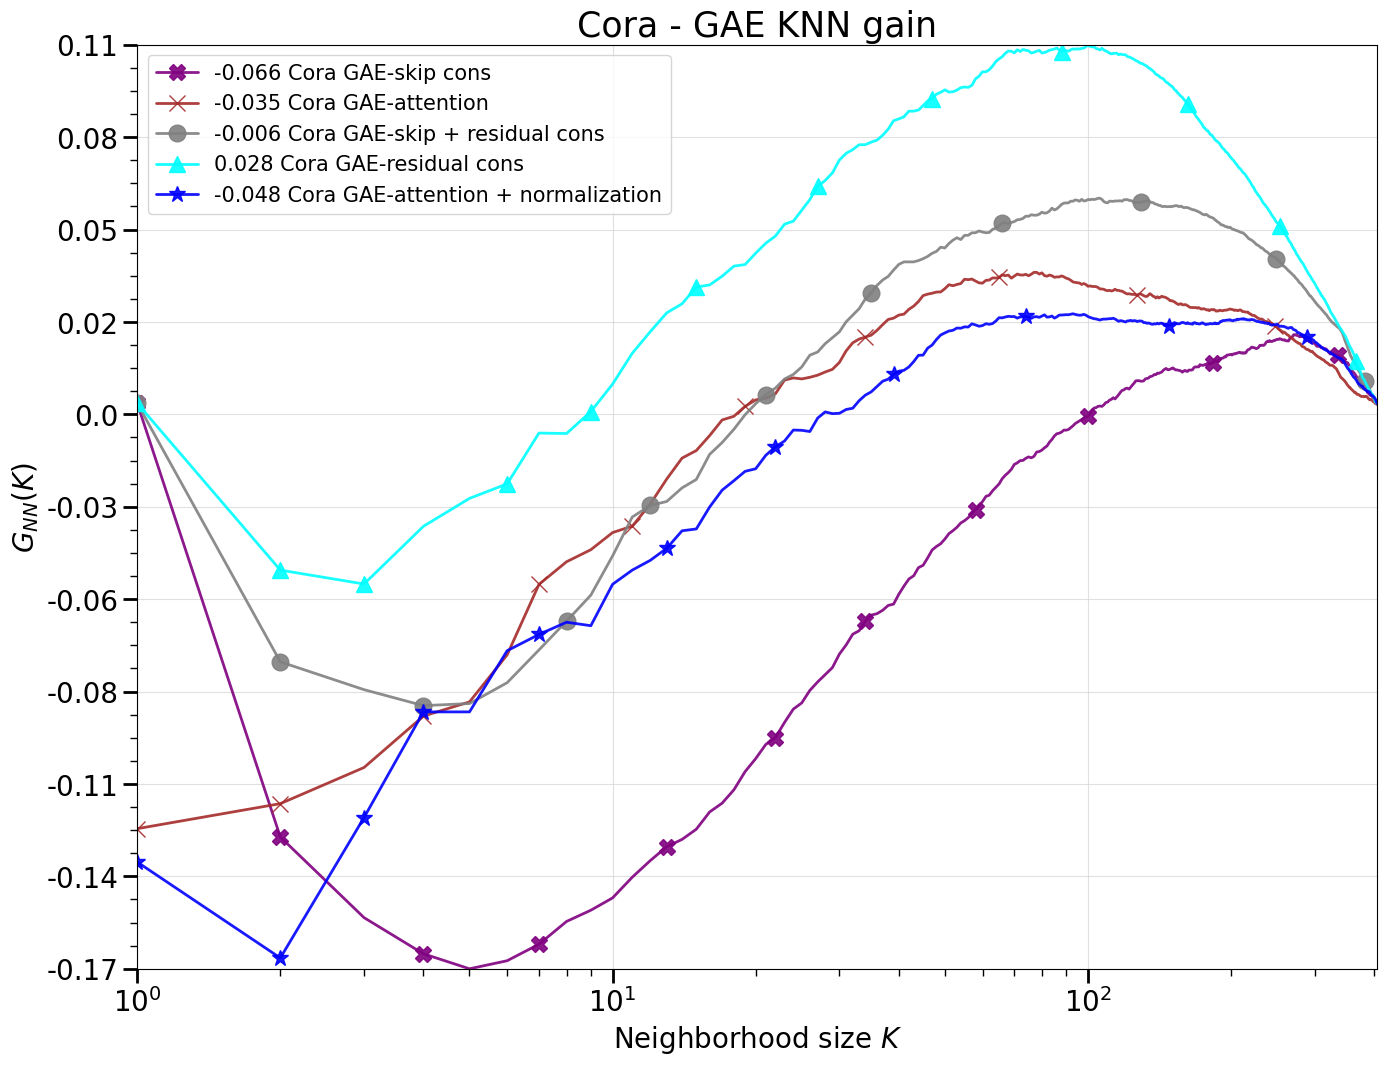

In [71]:
local_metrics.visualize(f"{dataset_name} - {algorithm_name}")

Finished.


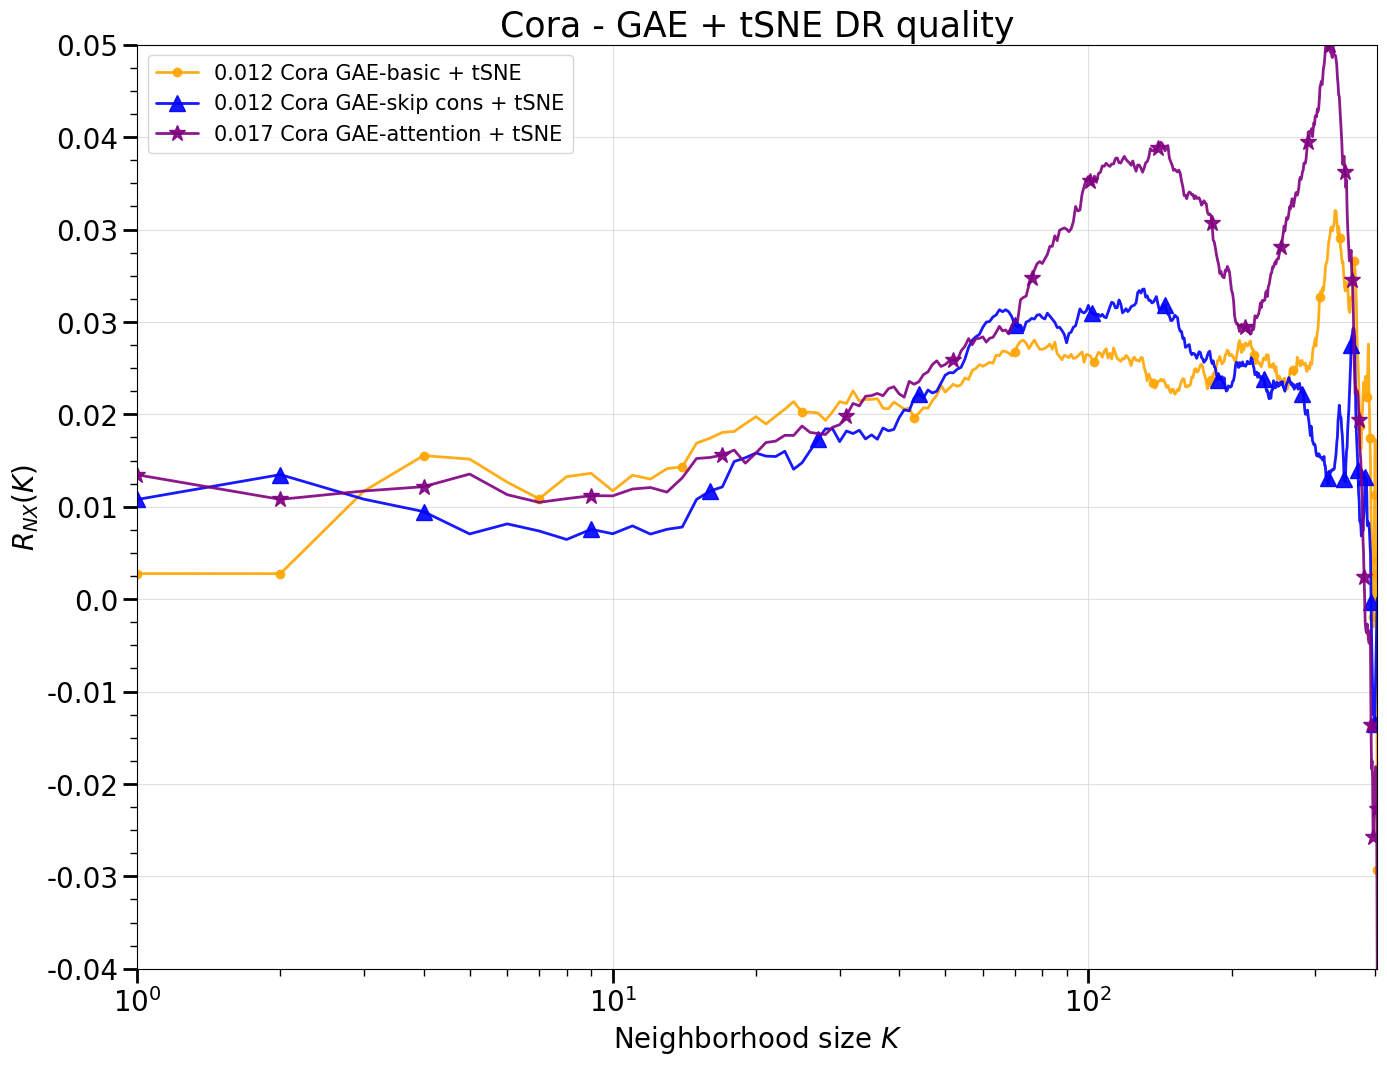

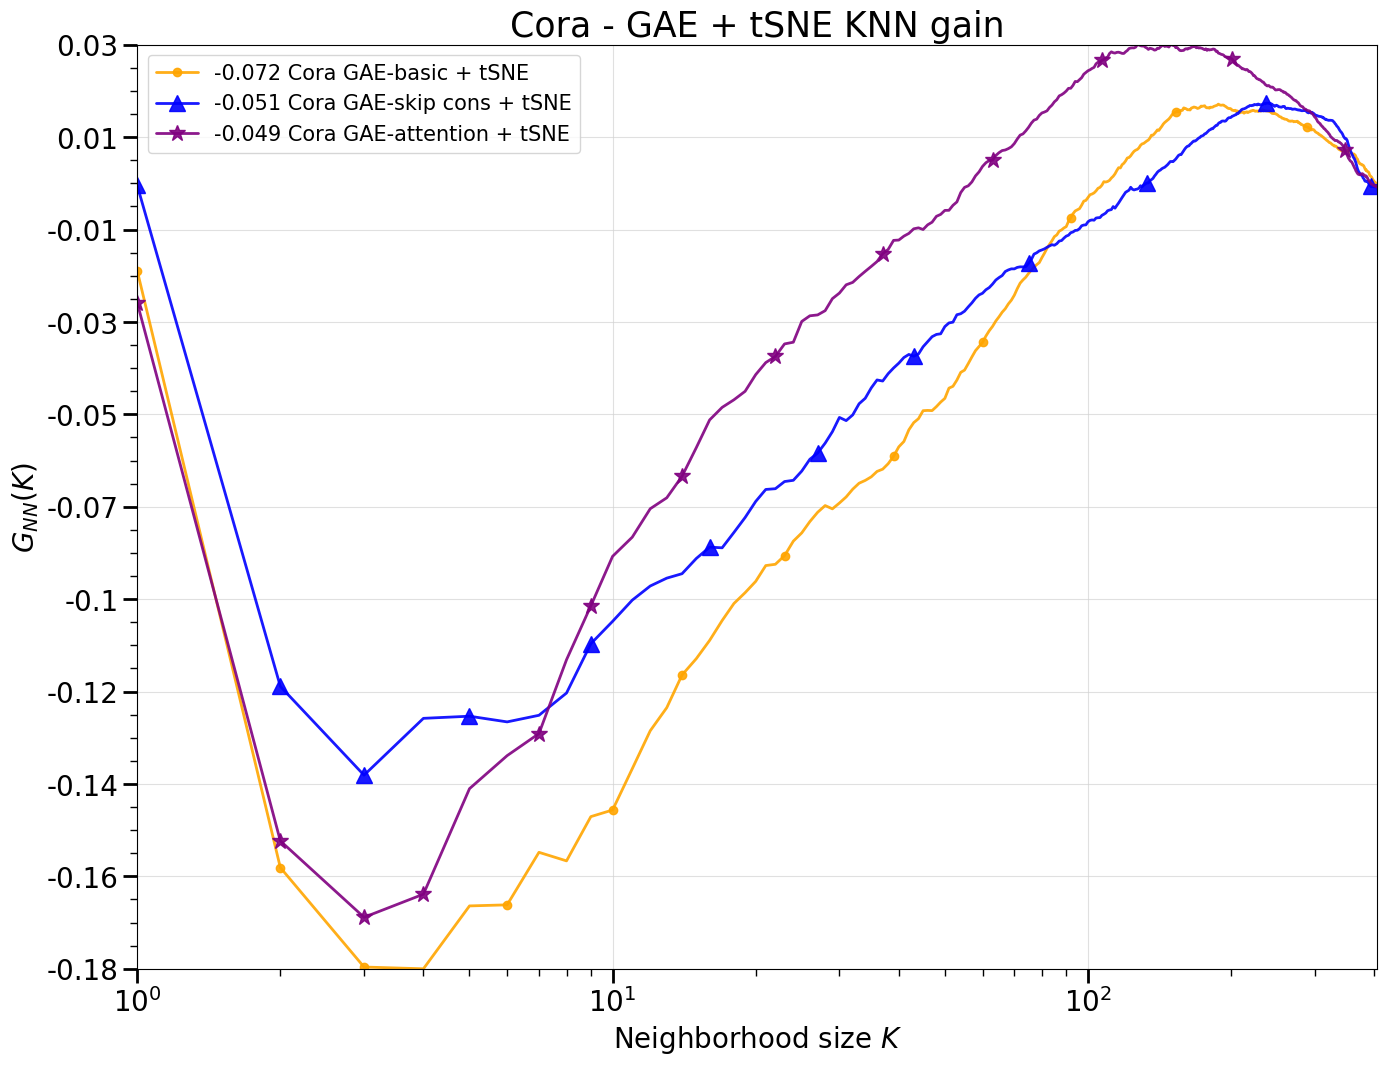

In [72]:
local_metrics_tsne.visualize(f"{dataset_name} - {algorithm_name} + tSNE")